In [1]:
# import5ing neccesary libraries
import warnings
warnings.filterwarnings('ignore')
from alpha_vantage.timeseries import TimeSeries
import json
import pandas as pd
from sklearn import preprocessing
import numpy as np
import keras
import tensorflow as tf
from keras.models import Model
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
import numpy as np
np.random.seed(4)
tf.random.set_seed(4)
import matplotlib as mpl
from keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import style
model_check = ModelCheckpoint('intel.h5', save_best_only = True, verbose = 1, )
import os
import stocker
import yfinance as yf
from googlefinance.get import get_code
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models.widgets import Dropdown
from bokeh.models import BooleanFilter, CDSView 
from bokeh.io import curdoc, output_notebook, push_notebook, show
from bokeh.layouts import column
from bokeh.models import CDSView, Select, Range1d, HoverTool
from bokeh.palettes import Category20
from bokeh.models.formatters import NumeralTickFormatter
import plotly.graph_objs as go
# Offline mode
from plotly.offline import init_notebook_mode, iplot

Using TensorFlow backend.


In [2]:
init_notebook_mode(connected = True)

In [10]:
#donot run again
spy = yf.Ticker("SPY")

# get historical market data
hist = spy.history(period = "max")

In [11]:
#do not run again
hist = hist.drop(['Dividends', 'Stock Splits'], axis = 1)
hist.to_csv('SPY_daily.csv', index = True)
hist.head()

,Open,High,Low,Close,Volume
Date,,,,,
1993-01-29,26.32,26.32,26.19,26.30,1003200
1993-02-01,26.32,26.49,26.32,26.49,480500
1993-02-02,26.47,26.56,26.41,26.54,201300
1993-02-03,26.58,26.84,26.56,26.82,529400
1993-02-04,26.92,26.99,26.62,26.94,531500


In [3]:
# Define constants
W_PLOT = 1500
H_PLOT = 600
TOOLS = 'pan,wheel_zoom,hover,reset'

VBAR_WIDTH = 0.2
RED = Category20[7][6]
GREEN = Category20[5][4]

BLUE = Category20[3][0]
BLUE_LIGHT = Category20[3][1]

ORANGE = Category20[3][2]
PURPLE = Category20[9][8]
BROWN = Category20[11][10]

In [5]:
def get_symbol_df(symbol = None):
    df = pd.read_csv(symbol + '.csv')
    #df = df.iloc[::-1]
    #df =  df.reset_index(drop = True)
    #df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    #df["Date"] = pd.to_datetime(df["Date"])
    return df

In [6]:
def plot_stock_price(stock):
    p = figure(plot_width = W_PLOT, plot_height = H_PLOT, tools = TOOLS, title = "Stock price", toolbar_location = 'above')
    inc = stock.data['Close'] > stock.data['Open']
    dec = stock.data['Open'] > stock.data['Close']
    view_inc = CDSView(source = stock, filters = [BooleanFilter(inc)])
    view_dec = CDSView(source = stock, filters = [BooleanFilter(dec)])

    # map dataframe indices to date strings and use as label overrides
    p.xaxis.major_label_overrides = {i+int(stock.data['index'][0]): date.strftime('%b %d') for i, date in enumerate(pd.to_datetime(stock.data["Date"]))}
    p.xaxis.bounds = (stock.data['index'][0], stock.data['index'][-1])


    p.segment(x0 = 'index', x1 = 'index', y0 = 'Low', y1 = 'High', color = RED, source = stock, view = view_inc)
    p.segment(x0 = 'index', x1 = 'index', y0 = 'Low', y1 = 'High', color = GREEN, source = stock, view = view_dec)

    p.vbar(x = 'index', width = VBAR_WIDTH, top = 'Open', bottom = 'Close', fill_color = BLUE, line_color = BLUE, source = stock, view = view_inc, name = "price")
    p.vbar(x = 'index', width = VBAR_WIDTH, top = 'Open', bottom = 'Close', fill_color = RED, line_color = RED, source = stock, view = view_dec, name = "price")

    p.legend.location = "top_left"
    p.legend.border_line_alpha = 0
    p.legend.background_fill_alpha = 0
    p.legend.click_policy = "mute"

    p.yaxis.formatter = NumeralTickFormatter(format='$ 0,0[.]000')
    p.x_range.range_padding = 0.05
    p.xaxis.major_label_orientation = 3.14/4
    
    # Select specific tool for the plot
    price_hover = p.select(dict(type=HoverTool))

    # Choose, which glyphs are active by glyph name
    price_hover.names = ["price"]
    # Creating tooltips
    price_hover.tooltips = [("Datetime", "@Date{%Y-%m-%d}"), ("Open", "@Open{$0,0.00}"), ("Close", "@Close{$0,0.00}"), ("Volume", "@Volume{($ 0.00 a)}")]
    price_hover.formatters = {"Date": 'datetime'}

    return p

In [7]:
stock = ColumnDataSource(data = dict(Date = [], Open = [], Close = [], High = [], Low = [],index = []))
symbol = 'SPY_daily'
df = get_symbol_df(symbol)
stock.data = stock.from_df(df)
elements = list()

In [8]:
# update_plot()
p_stock = plot_stock_price(stock)

elements.append(p_stock)

curdoc().add_root(column(elements))
curdoc().title = 'Bokeh stocks historical prices'

In [9]:
output_notebook()

Loading BokehJS ...

In [10]:
show(p_stock)

In [11]:
df = pd.read_csv('SPY_daily.csv')
df = df.set_index('Date')
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
1993-01-29,26.32,26.32,26.19,26.30,1003200
1993-02-01,26.32,26.49,26.32,26.49,480500
1993-02-02,26.47,26.56,26.41,26.54,201300
1993-02-03,26.58,26.84,26.56,26.82,529400
1993-02-04,26.92,26.99,26.62,26.94,531500


In [12]:
df.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2020-04-03,250.76,253.32,245.22,248.19,135561200
2020-04-06,257.84,267.00,248.17,264.86,188061200
2020-04-07,274.21,275.03,264.89,265.13,201427200
2020-04-08,267.96,276.00,265.25,274.03,153774500
2020-04-09,277.58,281.20,275.47,278.20,190282700


In [13]:
open_data = go.Scatter(x = df.Open.index, y = df.Open.values, showlegend = True, name = 'Open')
close_data = go.Scatter(x = df.Close.index, y = df.Close.values, showlegend = True, name = 'Close')
layout = go.Layout(height = 600, width = 800,
                   title = 'Open and Close values Plot',
                   # Same x and first y
                   xaxis = dict(title = 'Date'),
                   yaxis = dict(title = 'Stock Value ($)')
                   )

fig = go.Figure(data = [open_data, close_data], layout = layout)
iplot(fig, show_link = 'True')

In [11]:
high_data = go.Scatter(x = df.High.index, y = df.High.values, showlegend = True, name = 'High')
low_data = go.Scatter(x = df.Low.index, y = df.Low.values, showlegend = True, name = 'Low')
layout = go.Layout(height = 600, width = 800,
                   title = 'High and Low values Plot',
                   # Same x and first y
                   xaxis = dict(title = 'Date'),
                   yaxis = dict(title = 'Stock Value ($)')
                   )

fig = go.Figure(data = [high_data, low_data], layout = layout)
iplot(fig, show_link = 'True')

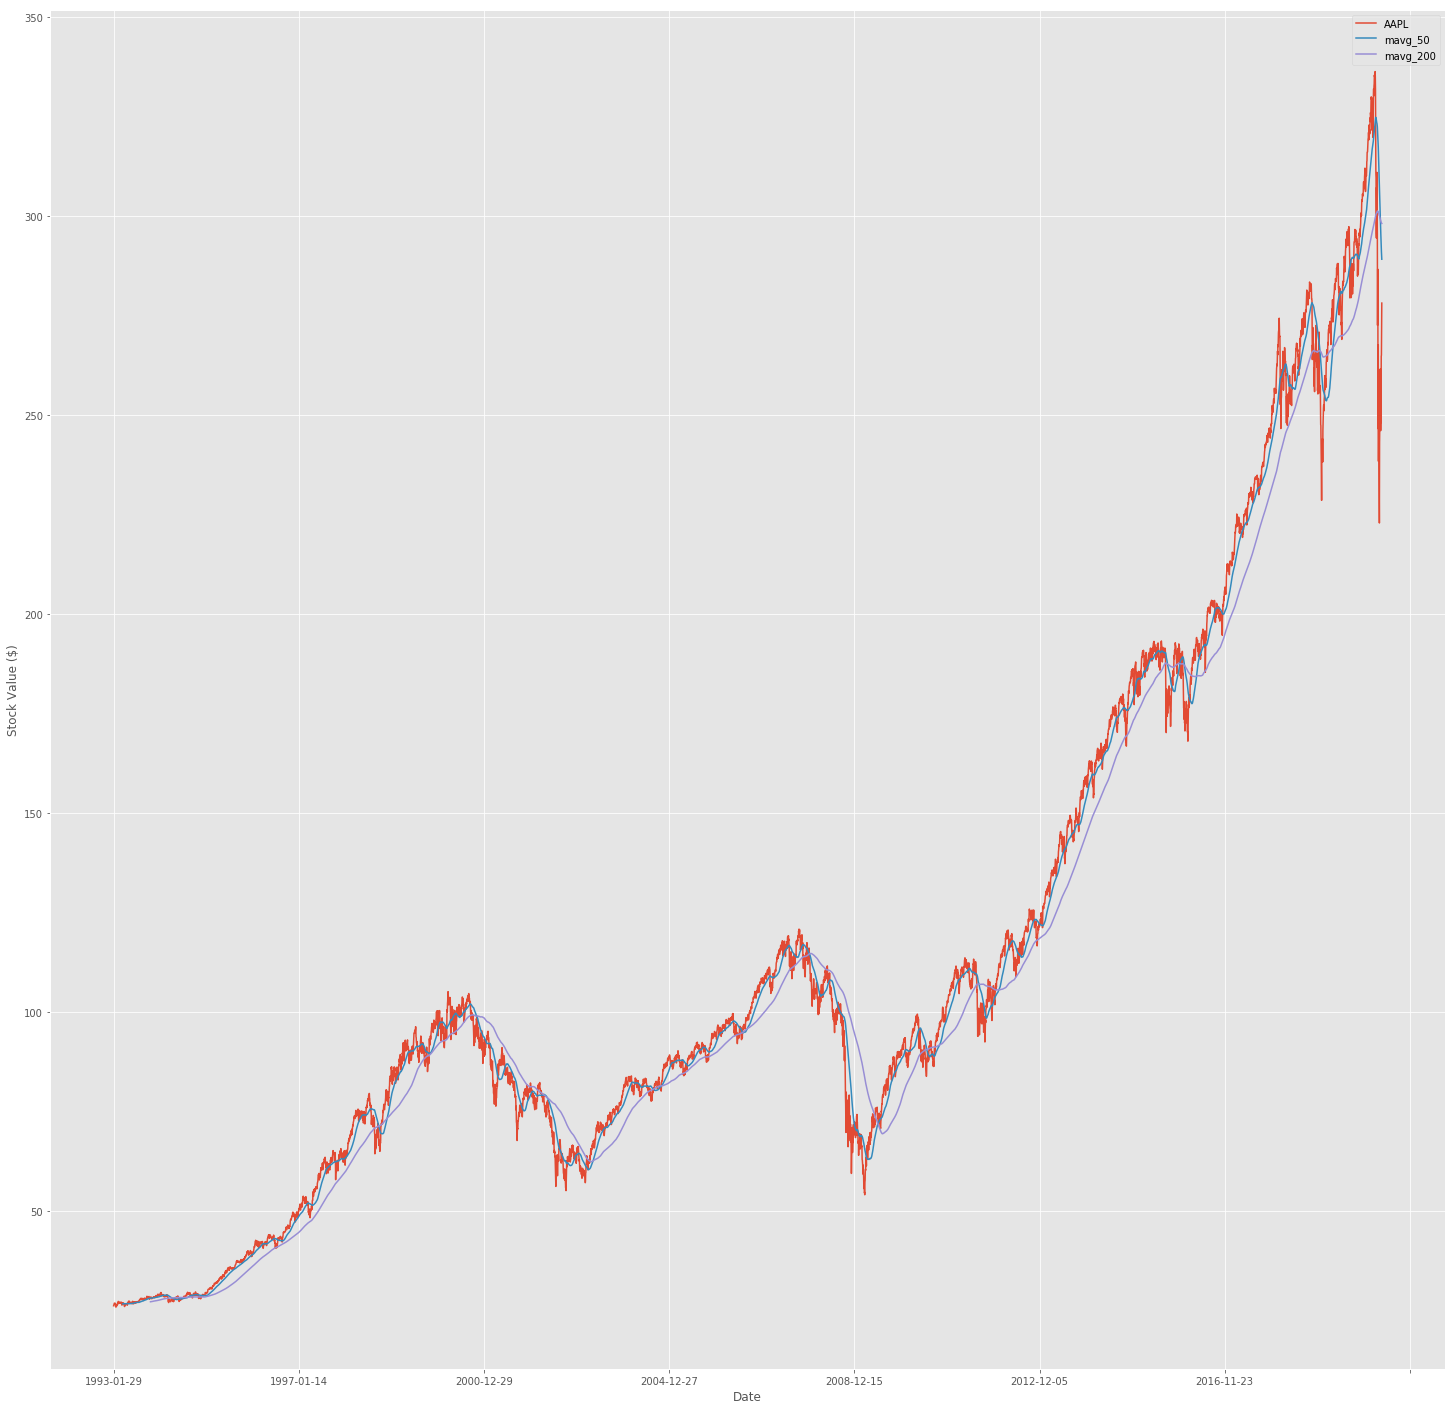

In [16]:
close_px = df['Close']
mavg_50 = close_px.rolling(window = 50).mean()
mavg_200 = close_px.rolling(window = 200).mean()

mpl.rc('figure', figsize = (25, 25))
style.use('ggplot')

close_px.plot(label = 'AAPL')
mavg_50.plot(label = 'mavg_50')
mavg_200.plot(label = 'mavg_200')
plt.ylabel('Stock Value ($)')
plt.legend()
plt.show()

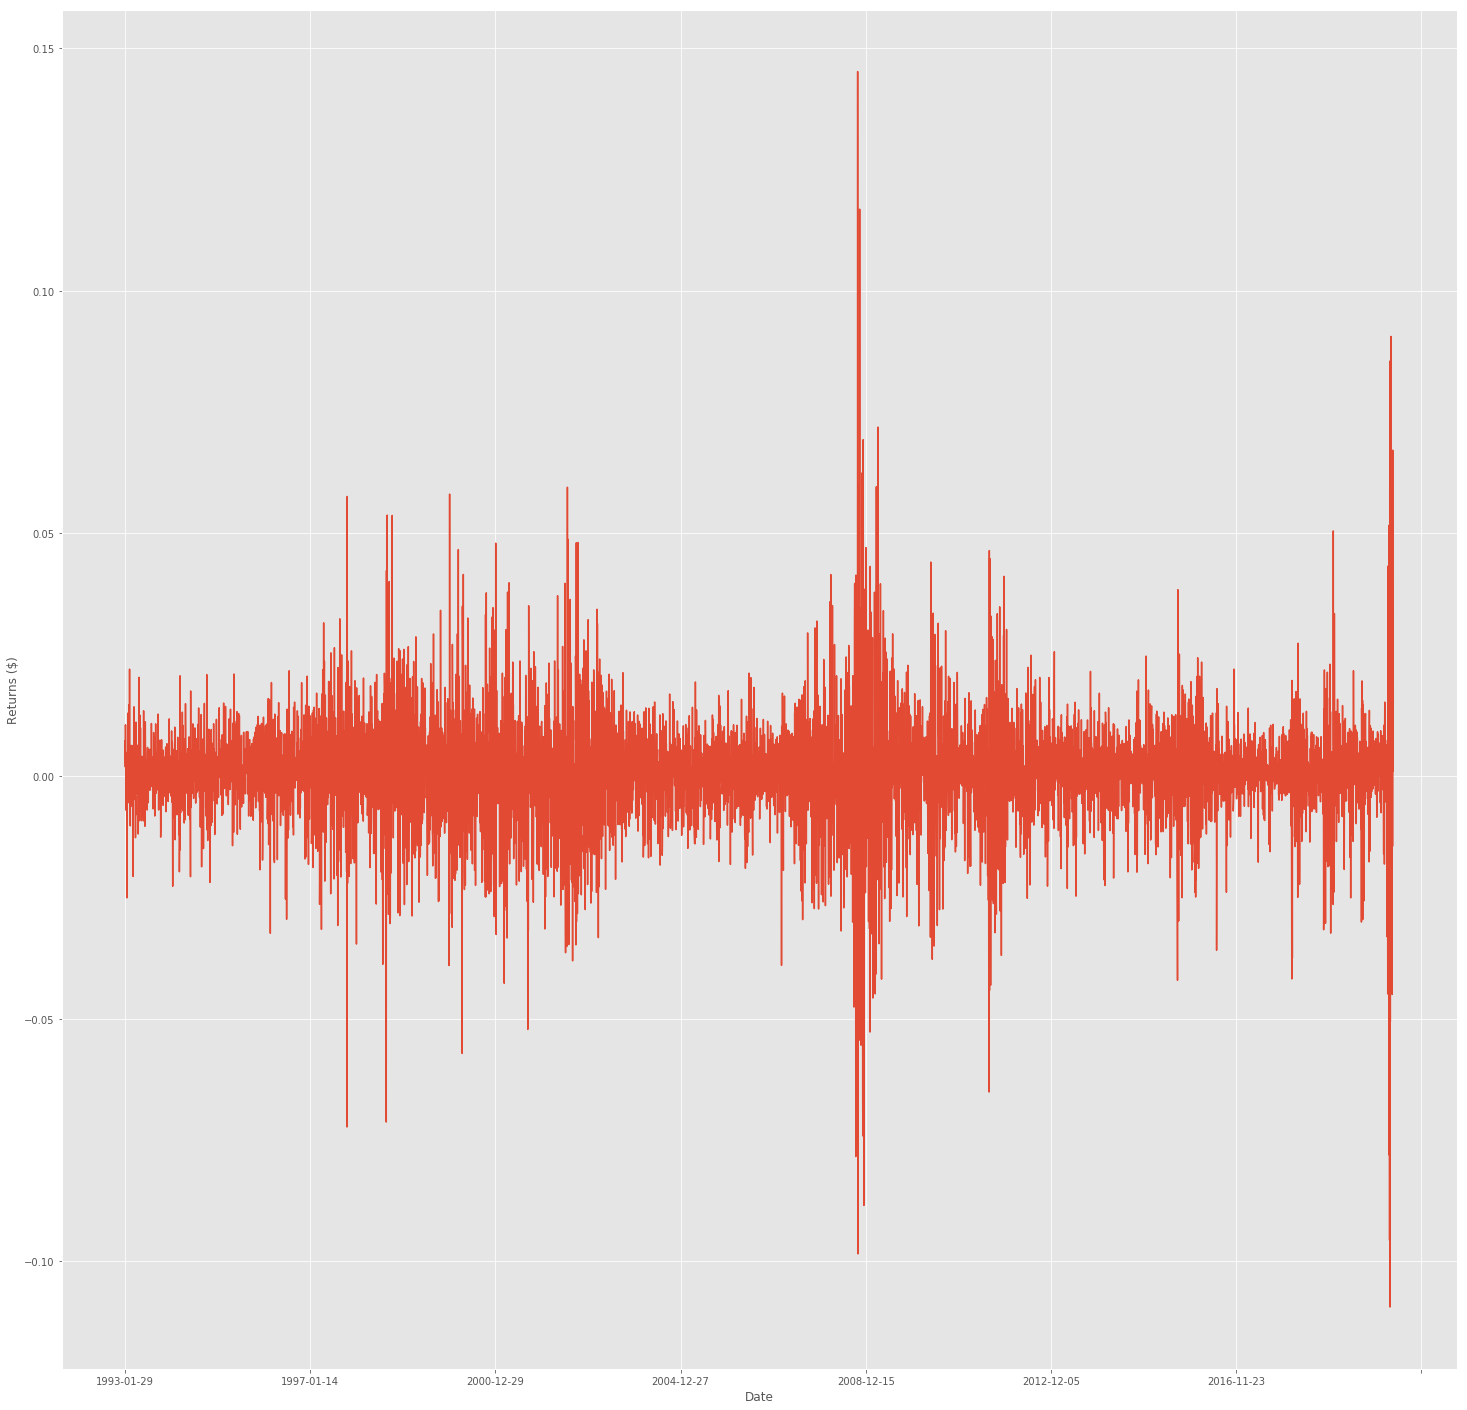

In [17]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label = 'return')
plt.ylabel('Returns ($)')
plt.show()

In [18]:
retscomp = df['Close'].pct_change()
retscomp

Date
1993-01-29         NaN
1993-02-01    0.007224
1993-02-02    0.001888
1993-02-03    0.010550
1993-02-04    0.004474
                ...   
2020-04-03   -0.014454
2020-04-06    0.067166
2020-04-07    0.001019
2020-04-08    0.033568
2020-04-09    0.015217
Name: Close, Length: 6849, dtype: float64

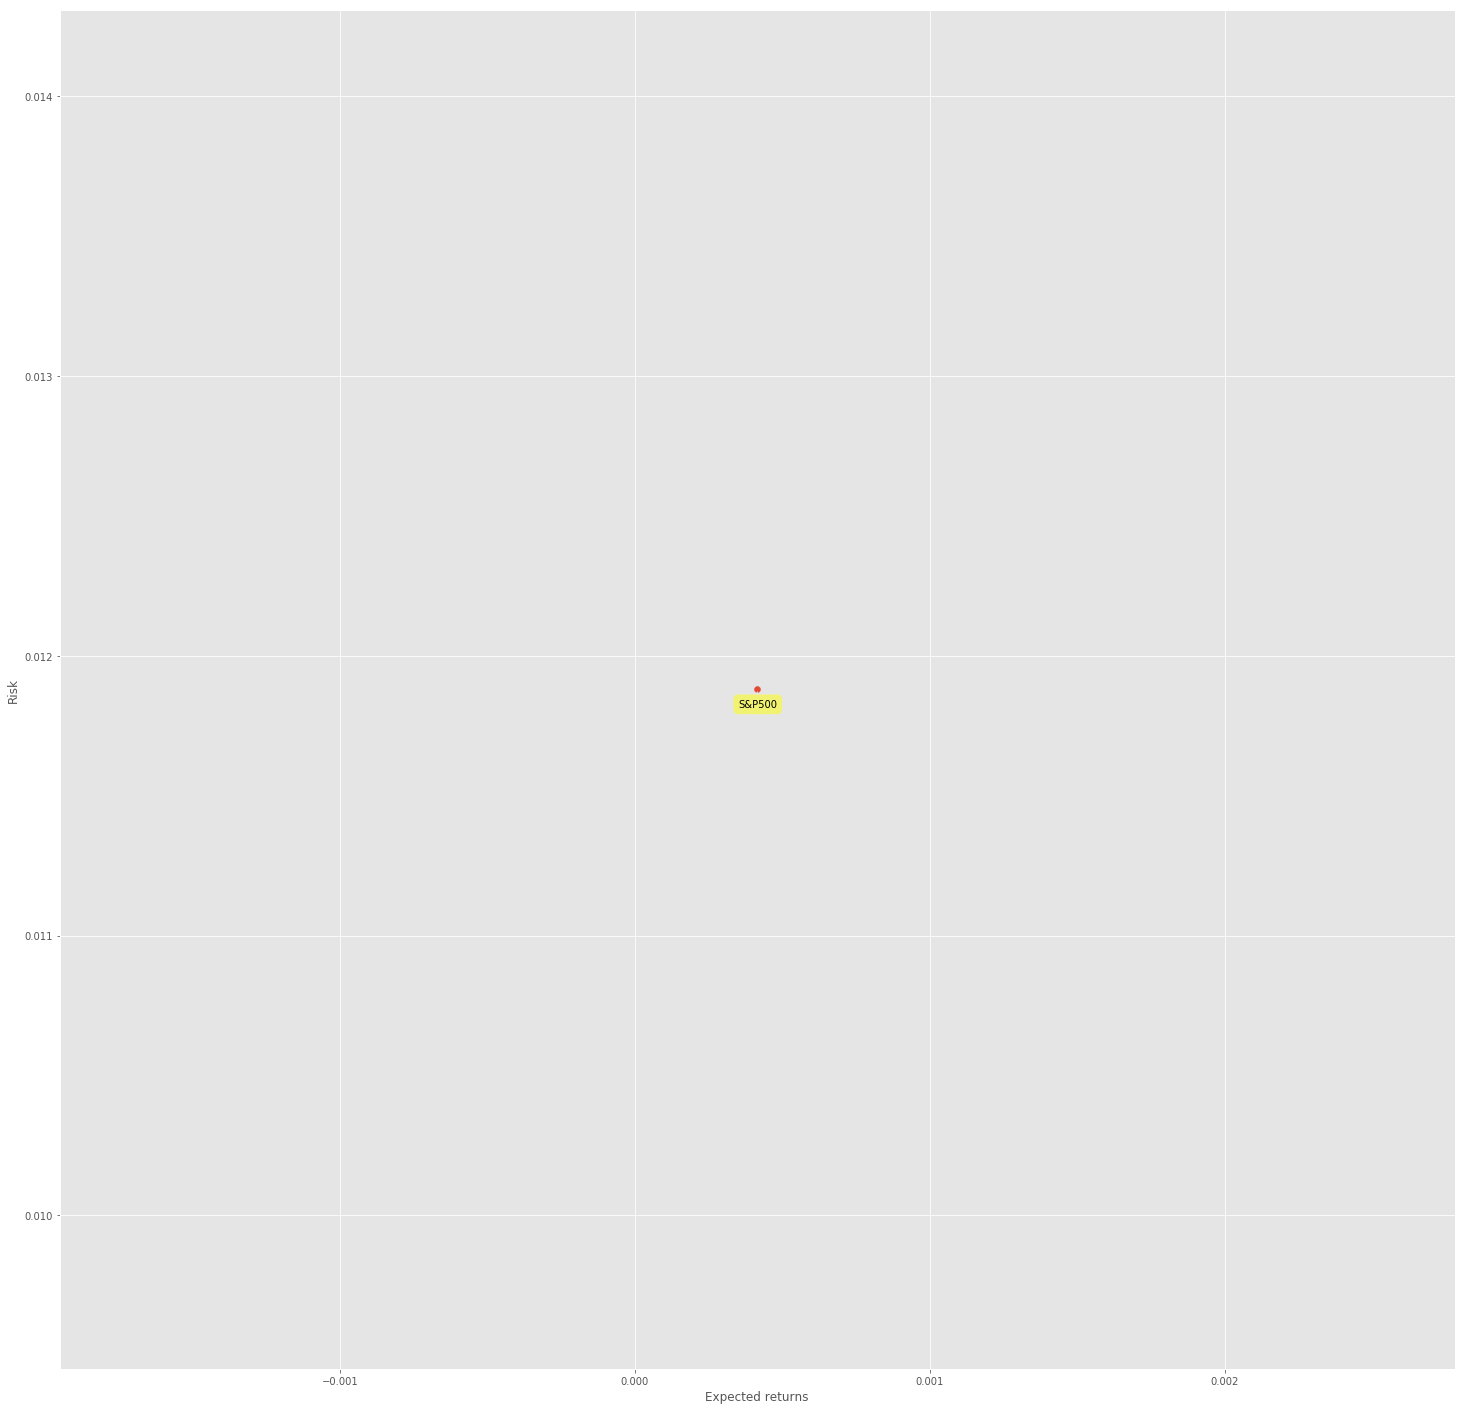

In [19]:
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
plt.annotate('S&P500', xy = (retscomp.mean(), retscomp.std()), xytext = (20, -20), textcoords = 'offset points', ha = 'right', va = 'bottom', bbox = dict(boxstyle = 'round,pad = 0.5', fc = 'yellow', alpha = 0.5), arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad = 0'))
plt.show()

In [18]:
def save_dataset(symbol):
    ts = TimeSeries(key = '1D73JH5MBBFLJ7LC', output_format = 'pandas')
    data, meta_data = ts.get_daily(symbol, outputsize = 'full')

    data.to_csv(f'./{symbol}_daily.csv')

In [10]:
save_dataset('SPY')

In [20]:
history_points = 60

def csv_to_dataset(csv_path):
    data = pd.read_csv(csv_path)
    #data = data.iloc[::-1]
    #data = data.reset_index(drop = True)
    
    data = data.drop('Date', axis = 1)
    data = data.drop(0, axis = 0)
    
    data.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    
    data['HL_PCT'] = (data['High'] - data['Low']) / data['Close'] * 100.0
    data['PCT_change'] = (data['Close'] - data['Open']) / data['Open'] * 100.0
    
    data = data.values
    
    data_normaliser = preprocessing.MinMaxScaler()
    data_normalised = data_normaliser.fit_transform(data)
    
    # using the last {history_points} open high low close volume data points, predict the next open value
    ohlcv_histories_normalised  = np.array([data_normalised[i  : i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    next_day_open_values_normalised = np.array([data_normalised[:, 0][i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    next_day_open_values_normalised = np.expand_dims(next_day_open_values_normalised, -1)

    # prepating y_normalizer to get inv_transform
    next_day_open_values = np.array([data[:, 0][i + history_points].copy() for i in range(len(data) - history_points)])
    next_day_open_values = np.expand_dims(next_day_open_values, -1)
    y_normaliser = preprocessing.MinMaxScaler()
    y_normaliser.fit(next_day_open_values)
    
    def calc_ema(values, time_period):
        # https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp
        sma = np.mean(values[:, 3])
        ema_values = [sma]
        k = 2 / (1 + time_period)
        for i in range(len(his) - time_period, len(his)):
            close = his[i][3]
            ema_values.append(close * k + ema_values[-1] * (1 - k))
        return ema_values[-1]

    technical_indicators = []
    for his in ohlcv_histories_normalised:
        # note since we are using his[3] we are taking the SMA of the closing price
        sma = np.mean(his[:, 3])
        macd = calc_ema(his, 12) - calc_ema(his, 26)
        technical_indicators.append(np.array([sma, macd]))

    technical_indicators = np.array(technical_indicators)

    tech_ind_scaler = preprocessing.MinMaxScaler()
    technical_indicators_normalised = tech_ind_scaler.fit_transform(technical_indicators)

    assert ohlcv_histories_normalised.shape[0] == next_day_open_values_normalised.shape[0] == technical_indicators_normalised.shape[0]
    return ohlcv_histories_normalised, technical_indicators_normalised, next_day_open_values_normalised, next_day_open_values, y_normaliser

In [21]:
ohlcv_histories, technical_indicators, next_day_open_values, unscaled_y, y_normaliser = csv_to_dataset('SPY_daily.csv')

In [22]:
test_split = 0.8
n = int(ohlcv_histories.shape[0] * test_split)

ohlcv_train = ohlcv_histories[:n]
tech_ind_train = technical_indicators[:n]
y_train = next_day_open_values[:n]

ohlcv_test = ohlcv_histories[n:]
tech_ind_test = technical_indicators[n:]
y_test = next_day_open_values[n:]

unscaled_y_test = unscaled_y[n:]

print(ohlcv_train.shape)
print(ohlcv_test.shape)

(5430, 60, 7)
(1358, 60, 7)


In [23]:
# model architecture

# define two sets of inputs
lstm_input = Input(shape = (history_points, 7), name = 'lstm_input')
dense_input = Input(shape = (technical_indicators.shape[1], ), name = 'tech_input')

# the first branch operates on the first input
x = LSTM(60, name = 'lstm_0')(lstm_input)
x = Dropout(0.2, name = 'lstm_dropout_0')(x)
lstm_branch = Model(inputs = lstm_input, outputs = x)

# the second branch opreates on the second input
y = Dense(20, name = 'tech_dense_0')(dense_input)
y = Activation("relu", name = 'tech_relu_0')(y)
y = Dropout(0.2, name = 'tech_dropout_0')(y)
technical_indicators_branch = Model(inputs = dense_input, outputs = y)

# combine the output of the two branches
combined = concatenate([lstm_branch.output, technical_indicators_branch.output], name = 'concatenate')
z = Dense(64, activation = "sigmoid", name = 'dense_pooling')(combined)
z = Dense(1, activation = "linear", name = 'dense_out')(z)

# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs = [lstm_branch.input, technical_indicators_branch.input], outputs = z)
adam = optimizers.Adam(lr = 0.0005)
model.compile(optimizer = adam, loss = 'mse')

In [24]:
hist = model.fit(x = [ohlcv_train, tech_ind_train], y = y_train, batch_size = 32, epochs = 50, shuffle = True, validation_split = 0.1, callbacks = [model_check])

Train on 4887 samples, validate on 543 samples
Epoch 1/50
4887/4887 [==============================] - 5s 1ms/step - loss: 0.0017 - val_loss: 0.0016

Epoch 00001: val_loss improved from inf to 0.00164, saving model to intel.h5
Epoch 2/50
4887/4887 [==============================] - 5s 988us/step - loss: 1.8164e-04 - val_loss: 0.0020

Epoch 00002: val_loss did not improve from 0.00164
Epoch 3/50
4887/4887 [==============================] - 5s 986us/step - loss: 1.3429e-04 - val_loss: 0.0012

Epoch 00003: val_loss improved from 0.00164 to 0.00118, saving model to intel.h5
Epoch 4/50
4887/4887 [==============================] - 5s 997us/step - loss: 1.1440e-04 - val_loss: 5.3988e-04

Epoch 00004: val_loss improved from 0.00118 to 0.00054, saving model to intel.h5
Epoch 5/50
4887/4887 [==============================] - 5s 1ms/step - loss: 1.0312e-04 - val_loss: 5.7814e-04

Epoch 00005: val_loss did not improve from 0.00054
Epoch 6/50
4887/4887 [==============================] - 5s 1ms/step

4887/4887 [==============================] - 5s 975us/step - loss: 4.6805e-05 - val_loss: 1.4885e-05

Epoch 00049: val_loss did not improve from 0.00001
Epoch 50/50
4887/4887 [==============================] - 5s 974us/step - loss: 4.2164e-05 - val_loss: 8.7066e-06

Epoch 00050: val_loss did not improve from 0.00001


In [25]:
model.evaluate([ohlcv_test, tech_ind_test], y_test, verbose = 1)

1358/1358 [==============================] - 0s 286us/step


9.052416595866264e-05

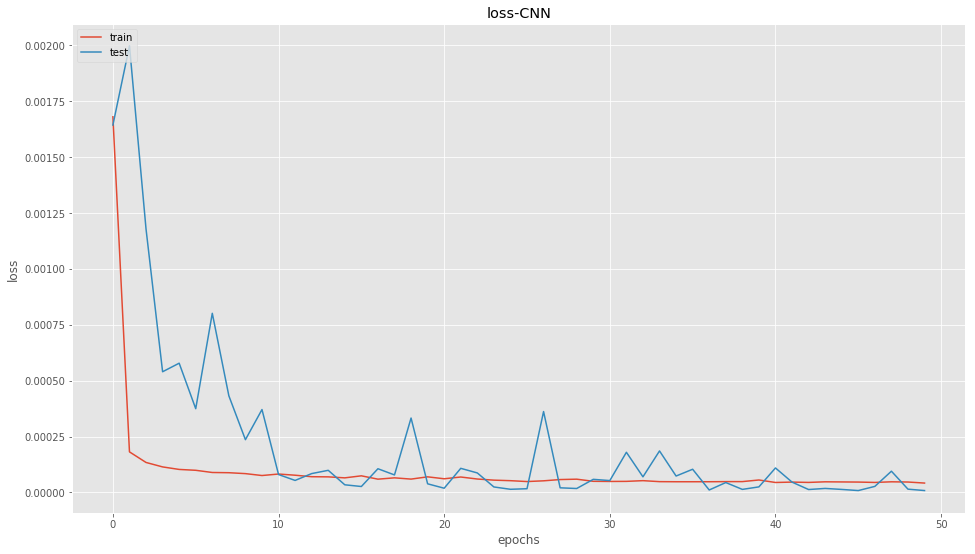

In [26]:
#plot
plt.figure(figsize = (16, 9))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc = 'upper left')
plt.title('loss-CNN')
plt.show()

In [27]:
# evaluation

y_test_predicted = model.predict([ohlcv_test, tech_ind_test])
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
y_predicted = model.predict([ohlcv_histories, technical_indicators])
y_predicted = y_normaliser.inverse_transform(y_predicted)
assert unscaled_y_test.shape == y_test_predicted.shape
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)

4.99788946390056


In [28]:
df = pd.read_csv('SPY_daily.csv')
df.head()
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
df = df.reset_index(drop = True)
df.head()

,Date,Open,High,Low,Close,Volume
0,1993-01-29,26.32,26.32,26.19,26.30,1003200
1,1993-02-01,26.32,26.49,26.32,26.49,480500
2,1993-02-02,26.47,26.56,26.41,26.54,201300
3,1993-02-03,26.58,26.84,26.56,26.82,529400
4,1993-02-04,26.92,26.99,26.62,26.94,531500


In [29]:
predictions = pd.DataFrame({'Date' : df.iloc[n + 61:, 0].values, 'Actual_Open' : df.iloc[n + 61:, 1].values, 'Predicted_Open' : y_test_predicted.ravel()})
predictions = predictions.set_index('Date')
#predictions['Date'] = pd.to_datetime(predictions['Date'])

In [30]:
predictions.head()

,Actual_Open,Predicted_Open
Date,,
2014-11-17,182.64,183.287003
2014-11-18,183.17,183.395172
2014-11-19,183.95,183.826385
2014-11-20,183.01,183.681015
2014-11-21,186.04,184.116623


In [31]:
actual_open_data = go.Scatter(x = predictions.Actual_Open.index, y = predictions.Actual_Open.values, showlegend = True, name = 'Actual Open')
predicted_open_data = go.Scatter(x = predictions.Predicted_Open.index, y = predictions.Predicted_Open.values, showlegend = True, name = 'Predicted Open')
layout = go.Layout(height = 600, width = 800,
                   title = 'Actual & Predicted Open values Plot',
                   # Same x and first y
                   xaxis = dict(title = 'Date'),
                   yaxis = dict(title = 'Stock Value ($)')
                   )

fig = go.Figure(data = [actual_open_data, predicted_open_data], layout = layout)
iplot(fig, show_link = 'True')